<a href="https://colab.research.google.com/github/ldt9/Portfolio-Tearsheet-Return-Generator/blob/main/Portfolio_Tear_Sheet_Generator_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio-Tearsheet-Return-Generator
## Overview
This program creates a brief, two-page document for an investor to summarize the historical outcome of the investor's portfolio transactions over the selected time period. 

## Goals of this Project
1. Allow investors to input their tranaction data via a .csv file
2. Handle time-series transactions based on First-In-First-Out (FIFO) Logic
3. Utilize the QuantStats library to display portfolio statistics against a benchmark
4. Print the statistics output to a .pdf for simpler sharing

## Function Explanations

#### `` def create_market_cal(start, end) ``
- Uses the pandas_market_calendars library to find all relevant trading days within a specified timeframe
- Automatically filters out non-trading days based on the market 
- Sets NYSE as the calendar, and then standardizes the timestamps to make them easy to join on later

#### `` def read_csv(folder, csv_name) ``
- Takes a folder name and filename for where the .csv if located and creates a dataframe out of it

#### `` def get_data(stocks, start, end) ``
- Takes an array of stock tickers with a start and end date and grabs the data using the YFinance library

#### `` def position_adjust(daily_positions, sale) ``
- Create an empty dataframe called stocks_with_sales to which we'll add adjusted positions, and another dataframe holding all of the transactions labeled as buys

#### `` def portfolio_start_balance(portfolio, start_date) ``
- Add to the adjusted positions dataframe, the positions that never had sales, sales that occur in the future, and any zeroed out rows to create a record of your active holdings as of the start date

#### `` def fifo(daily_positions, sales, date) ``
- Flters sales to find any that have occurred on the current date and creates a dataframe of positions not affected by sales
- Then use `` position_adjust `` to zero-out any positions with active sales and append the positions with no changes, leaving you with an accurate daily snapshot of your porfolio positions

#### `` def time_fill(portfolio, market_cal) ``
- Provide our dataframe of active positions, find the sales, and zero-out sales against buy positions. 
- Loop through using our market_cal list with valid trading days
- Filter to positions that have occurred before or at the current date and make sure there are only buys. 
- Add a Date Snapshot column with the current date in the market_cal loop, then append it to our per_day_balance list

#### `` def modified_cost_per_share(portfolio, adj_close, start_date) ``
- Merges provided dataframes and calculates daily adjusted cost

#### `` def portfolio_end_of_year_stats(portfolio, adj_close_end) ``
- Finds end date closing prices for each ticker 

#### `` def portfolio_start_of_year_stats(portfolio, adj_close_start) ``
- Finds start date closing prices for each ticker

#### `` def calc_returns(portfolio) ``
- Applies a bunch of calculations against the data we’ve been modifying, and returns a final dataframe

#### `` def per_day_portfolio_calcs(per_day_holdings, daily_adj_close, stocks_start) ``
- Runs `` modified_cost_per_share ``, `` portfolio_end_of_year_stats ``, ``  portfolio_start_of_year_stats ``, `` calc_returns `` and returns a daily snapshot of the portfolio

#### `` def format_returns(pdpc, metric_to_group) ``
- Formats the per day portfolio calculations for use with the QuantStats library

#### `` def generate_report(returns, folder, rf=0.) ``
- Utilizes the QuantStats library to create a .html and .pdf of the tearsheet returns as well as display the output to the consol with quantitative statistics

## How to use this project in Google Colab
1. Connect to a Runtime
2. Press `` Ctrl + F9 ``

## Example Quick Start Main
``` Python
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Gather Data and Generate Report
generate_report('Tearsheet Generator', '2020-04-30')
```

## Example Input .csv
| Symbol        | Qty           | Type          | Open date      | Adj cost per share | Adj cost      |
| ------------- | ------------- | ------------- | ---------------| ------------------ | ------------- | 
| AAPL          | 10            | Buy           | 4/29/2020      | 71                 | 710           |
| MSFT          | 10            | Buy           | 5/1/2020       | 175                | 1750          |
| AAPL          | 5             | Sell.FIFO     | 5/15/2020      | 77                 | 385           |
|...|...|...|...|...|...|

## Example Output

### HTML
![quantstats-tearsheet](https://user-images.githubusercontent.com/84938803/210924445-0e251786-f38b-46d3-a78d-2d2b9e6539b5.jpg)

### PDF
[Tearsheet_2023-01-06.pdf](https://github.com/ldt9/Portfolio-Tearsheet-Return-Generator/files/10357085/Tearsheet_2023-01-06.pdf)

## Libraries Used
- [YFinance](https://github.com/ranaroussi/yfinance)
- [QuantStats](https://github.com/ranaroussi/quantstats)
- [PdfKit](https://github.com/JazzCore/python-pdfkit)
- [Pandas](https://github.com/pandas-dev/pandas)
- [Pandas Market Calendars](https://github.com/rsheftel/pandas_market_calendars)
- [MatPlotLib](https://github.com/matplotlib/matplotlib)

## References
- https://towardsdatascience.com/modeling-your-stock-portfolio-performance-with-python-fbba4ef2ef11
- https://github.com/mattygyo/stock_portfolio_analysis/blob/master/portfolio_analysis.py
- https://github.com/ranaroussi/quantstats

# ***Install and Import Libraries***

In [ ]:
!pip install yfinance==0.1.74 # For getting Price History of Assets
!pip install quantstats --upgrade --no-cache-dir # For calculating statistics based on Portfolio Value, SRC: https://github.com/ranaroussi/quantstats
!pip install pdfkit # For Converting an HTML file to a PdF
!wget https://github.com/wkhtmltopdf/packaging/releases/download/0.12.6-1/wkhtmltox_0.12.6-1.bionic_amd64.deb
!cp wkhtmltox_0.12.6-1.bionic_amd64.deb /usr/bin
!sudo apt install /usr/bin/wkhtmltox_0.12.6-1.bionic_amd64.deb
!pip install pandas
!pip install pandas_market_calendars

In [ ]:
# from datetime import date, datetime, timedelta
import datetime
import sys
import os
import math
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots
import itertools
import matplotlib.dates as mpl_dates
import yfinance as yf
import quantstats as qs
qs.extend_pandas()
import pdfkit
from pathlib import Path  

# ***Mount Drive to retrieve TXN Data***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Market Calendar***

In [ ]:
def create_market_cal(start, end):
  nyse = mcal.get_calendar('NYSE')
  schedule = nyse.schedule(start, end)
  market_cal = mcal.date_range(schedule, frequency='1D')
  market_cal = market_cal.tz_localize(None)
  market_cal = [i.replace(hour=0) for i in market_cal]
  return market_cal

# ***Downloading YFinance Data***

In [ ]:
def get_data(stocks, start, end):
  def data(ticker):
    df = yf.download(ticker, start=start, end=(datetime.datetime.strptime(end, "%Y-%m-%d") + datetime.timedelta(days=1)))
    df['symbol'] = ticker
    df.index = pd.to_datetime(df.index)
    return df
  datas = map(data,stocks)
  return(pd.concat(datas, keys=stocks, names=['Ticker', 'Date'], sort=True))

# ***Read from .CSV***

In [ ]:
def read_csv(folder, csv_name):
  portfolio_df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/{folder}/{csv_name}.csv')
  portfolio_df['Open date'] = pd.to_datetime(portfolio_df['Open date'])
  return portfolio_df

# ***Portfolio Position Initialization***

We need to figure out how many shares we actively held during the start date specified. To do that, we’re going to create two functions, portfolio_start_balance and position_adjust.

In [ ]:
def position_adjust(daily_positions, sale):
  stocks_with_sales = pd.DataFrame()
  buys_before_start = daily_positions[daily_positions['Type'] == 'Buy'].sort_values(by='Open date')
  for position in buys_before_start[buys_before_start['Symbol'] == sale[1]['Symbol']].iterrows():
      if position[1]['Qty'] <= sale[1]['Qty']:
          sale[1]['Qty'] -= position[1]['Qty']
          position[1]['Qty'] = 0
      else:
          position[1]['Qty'] -= sale[1]['Qty']
          sale[1]['Qty'] -= sale[1]['Qty']
      stocks_with_sales = stocks_with_sales.append(position[1])
  return stocks_with_sales

def portfolio_start_balance(portfolio, start_date):
  positions_before_start = portfolio[portfolio['Open date'] <= start_date]
  future_positions = portfolio[portfolio['Open date'] >= start_date]
  sales = positions_before_start[positions_before_start['Type'] == 'Sell.FIFO'].groupby(['Symbol'])['Qty'].sum()
  sales = sales.reset_index()
  positions_no_change = positions_before_start[~positions_before_start['Symbol'].isin(sales['Symbol'].unique())]
  adj_positions_df = pd.DataFrame()
  for sale in sales.iterrows():
      adj_positions = position_adjust(positions_before_start, sale)
      adj_positions_df = adj_positions_df.append(adj_positions)
  adj_positions_df = adj_positions_df.append(positions_no_change)
  adj_positions_df = adj_positions_df.append(future_positions)
  adj_positions_df = adj_positions_df[adj_positions_df['Qty'] > 0]
  return adj_positions_df

# ***FIFO - Daily Performace Snapshots***

In [ ]:
def fifo(daily_positions, sales, date):
  sales = sales[sales['Open date'] == date]
  daily_positions = daily_positions[daily_positions['Open date'] <= date]
  positions_no_change = daily_positions[~daily_positions['Symbol'].isin(sales['Symbol'].unique())]
  adj_positions = pd.DataFrame()
  for sale in sales.iterrows():
    adj_positions = adj_positions.append(position_adjust(daily_positions, sale))
  adj_positions = adj_positions.append(positions_no_change)  
  adj_positions = adj_positions[adj_positions['Qty'] > 0]
  return adj_positions

def time_fill(portfolio, market_cal):
  sales = portfolio[portfolio['Type'] == 'Sell.FIFO'].groupby(['Symbol','Open date'])['Qty'].sum()
  sales = sales.reset_index()
  per_day_balance = []
  for date in market_cal:
    if (sales['Open date'] == date).any():
      portfolio = fifo(portfolio, sales, date)
    else:
      daily_positions = portfolio[portfolio['Open date'] <= date]
      daily_positions = daily_positions[daily_positions['Type'] == 'Buy']
      daily_positions['Date Snapshot'] = date
      per_day_balance.append(daily_positions)
  return per_day_balance


# ***Calculating Portfolio Return***

Now that we have an accurate by-day ledger of our active holdings, we can go ahead and create the final calculations needed to generate graphs!

In [ ]:
def modified_cost_per_share(portfolio, adj_close, start_date):
  df = pd.merge(portfolio, adj_close, left_on=['Date Snapshot', 'Symbol'], right_on=['Date', 'Ticker'], how='left')
  df.rename(columns={'Close': 'Symbol Adj Close'}, inplace=True)
  df['Adj cost daily'] = df['Symbol Adj Close'] * df['Qty']
  df = df.drop(['Ticker', 'Date'], axis=1)
  return df

def portfolio_end_of_year_stats(portfolio, adj_close_end):
  adj_close_end = adj_close_end[adj_close_end['Date'] == adj_close_end['Date'].max()]
  portfolio_end_data = pd.merge(portfolio, adj_close_end, left_on='Symbol', right_on='Ticker')
  portfolio_end_data.rename(columns={'Close': 'Ticker End Date Close'}, inplace=True)
  portfolio_end_data = portfolio_end_data.drop(['Ticker', 'Date'], axis=1)
  return portfolio_end_data

def portfolio_start_of_year_stats(portfolio, adj_close_start):
  adj_close_start = adj_close_start[adj_close_start['Date'] == adj_close_start['Date'].min()]
  portfolio_start = pd.merge(portfolio, adj_close_start[['Ticker', 'Close', 'Date']], left_on='Symbol', right_on='Ticker')
  portfolio_start.rename(columns={'Close': 'Ticker Start Date Close'}, inplace=True)
  portfolio_start['Adj cost per share'] = np.where(portfolio_start['Open date'] <= portfolio_start['Date'], portfolio_start['Ticker Start Date Close'], portfolio_start['Adj cost per share'])
  portfolio_start['Adj cost'] = portfolio_start['Adj cost per share'] * portfolio_start['Qty']
  portfolio_start = portfolio_start.drop(['Ticker', 'Date'], axis=1)
  return portfolio_start

def calc_returns(portfolio):
  portfolio['Ticker Return'] = portfolio['Symbol Adj Close'] / portfolio['Adj cost per share'] - 1
  portfolio['Ticker Share Value'] = portfolio['Qty'] * portfolio['Symbol Adj Close']
  portfolio['Stock Gain / (Loss)'] = portfolio['Ticker Share Value'] - portfolio['Adj cost']
  return portfolio

def per_day_portfolio_calcs(per_day_holdings, daily_adj_close, stocks_start):
  df = pd.concat(per_day_holdings, sort=True)
  mcps = modified_cost_per_share(df, daily_adj_close, stocks_start)
  pes = portfolio_end_of_year_stats(mcps, daily_adj_close)
  pss = portfolio_start_of_year_stats(pes, daily_adj_close)
  returns = calc_returns(pss)
  return returns

def format_returns(pdpc, metric_to_group):
  grouped_metrics = pdpc.groupby(['Date Snapshot'])[[f'{metric_to_group}']].sum().reset_index()
  grouped_metrics = pd.melt(grouped_metrics, id_vars=['Date Snapshot'],
                                value_vars=[f'{metric_to_group}'])
  grouped_metrics.set_index('Date Snapshot', inplace=True) # Remove the RangeIndex and replace it with the Date

  # Debug
  # display(grouped_metrics) 

  returns = np.log(grouped_metrics['value']/grouped_metrics['value'].shift())
  returns.fillna(0, inplace=True)
  returns = returns.replace([np.inf, -np.inf], 0) 

  # Debug
  # display(returns)

  return returns



# ***Report Generation***

Utilize the QuantStats Library to generate a report for our Portfolio

In [ ]:
def generate_report(folder, start_date, rf=0.):
  print("Reading Portfolio Transactions from .CSV...")

  portfolio_df = read_csv('Tearsheet Generator', 'TransactionHistory2020-2022')

  # Create and Array of Unique Tickers
  symbols = portfolio_df.Symbol.unique()
  # print(symbols) # Debug

  today = datetime.datetime.today()
  stocks_end = today.strftime("%Y-%m-%d")
  # print(stocks_start, stocks_end) # Debug

  daily_adj_close = get_data(symbols, start_date, stocks_end)
  daily_adj_close = daily_adj_close[['Close']].reset_index() 
  # display(daily_adj_close) # Debug

  market_cal = create_market_cal(start_date, stocks_end)

  # display(portfolio_df) # Debug

  print('Determining Active Portfolio...')

  active_portfolio = portfolio_start_balance(portfolio_df, start_date)

  # Debug
  # display(active_portfolio)

  print('Calculating Daily Position Snapshots...')

  positions_per_day = time_fill(active_portfolio, market_cal)
  # display(positions_per_day)

  pdpc = per_day_portfolio_calcs(positions_per_day, daily_adj_close, start_date)
  # display(pdpc) # Debug

  # Debug - Checl Daily Snapshots
  # filepath = Path(f'/content/drive/MyDrive/Colab Notebooks/Tearsheet Generator/PerDayPortfolioCalculations_{datetime.date.today()}.csv')  
  # filepath.parent.mkdir(parents=True, exist_ok=True)  
  # pdpc.to_csv(filepath)  

  print('Formatting Returns for QuantStats Library...')

  portReturns = format_returns(pdpc, 'Ticker Share Value')

  print("Generating Report...")

  full = qs.reports.full(portReturns, benchmark='SPY', rf=rf, grayscale=False,
          figsize=(8, 5), display=True, compounded=True,
          periods_per_year=252, match_dates=False)

  doc = qs.reports.html(portReturns, benchmark='SPY', rf=rf, grayscale=False,
          title='Strategy Tearsheet', output=f'/content/drive/MyDrive/Colab Notebooks/{folder}/Tearsheet_{datetime.date.today()}.html', compounded=True,
          periods_per_year=252, download_filename='quantstats-tearsheet.html',
          figfmt='svg', template_path=None, match_dates=False)

  options = {
      'page-size': 'B4', 
      'margin-top': '0.10in',
      'margin-right': '0.0in',
      'margin-bottom': '0.0in',
      'margin-left': '0.10in'
      }
  pdfkit.from_file('quantstats-tearsheet.html', f'/content/drive/MyDrive/Colab Notebooks/{folder}/Tearsheet_{datetime.date.today()}.pdf', options=options)

  print("Report Generated in Colab as well as .html and .pdf")


# ***MAIN***

Reading Portfolio Transactions from .CSV...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



[Performance Metrics]

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2020-04-30  2020-04-30
End Period                 2023-01-09  2023-01-09
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          -41.2%      39.33%
CAGR﹪                     -17.88%     13.09%

Sharpe                     -0.64       0.74
Prob. Sharpe Ratio         13.71%      88.04%
Smart Sharpe               -0.61       0.7
Sortino                    -0.76       1.02
Smart Sortino              -0.72       0.97
Sortino/√2                 -0.54       0.72
Smart Sortino/√2           -0.51       0.68
Omega                      0.88        0.88

Max Drawdown               -53.32%     -24.5%
Longest DD Days            853         370
Volatility (ann.)          26.09%      19.81%
R^2                        0.68        0.68
Information Ratio          -0.13       -0.13
Calmar          

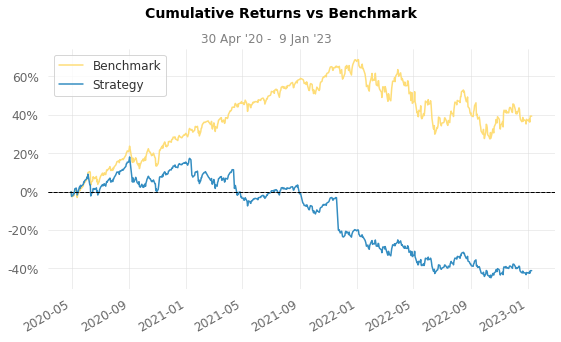

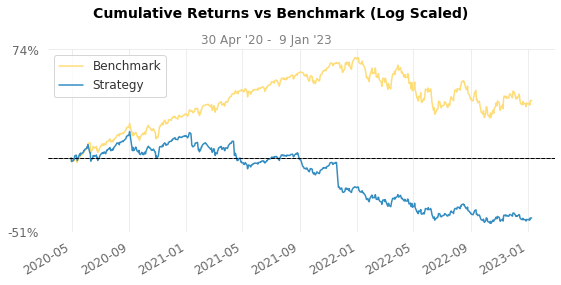

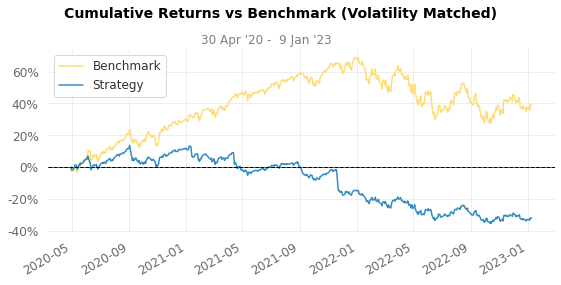

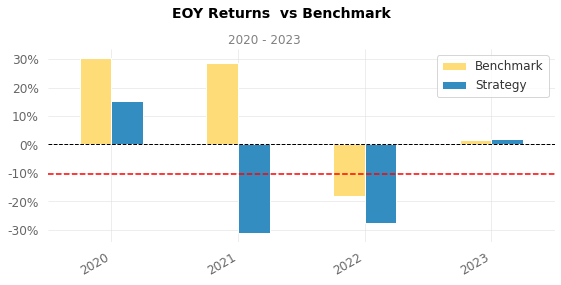

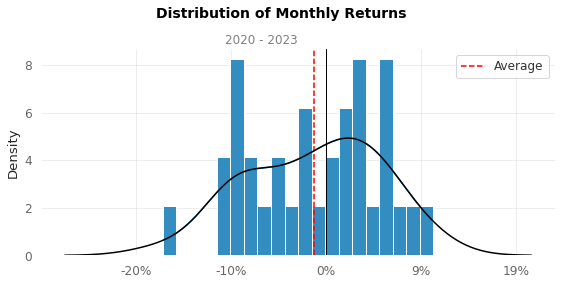

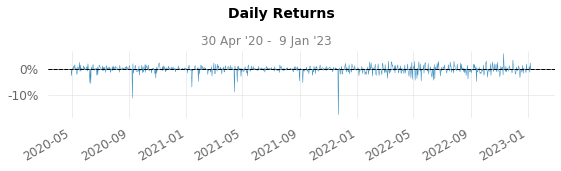

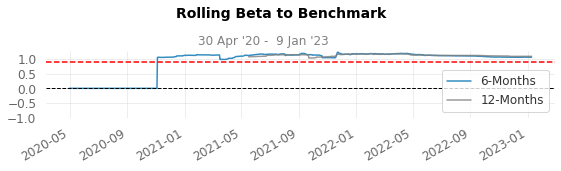

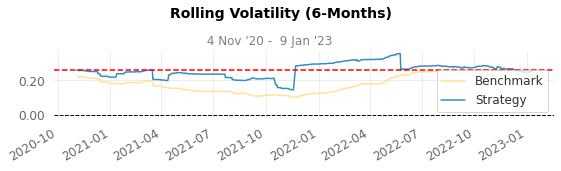

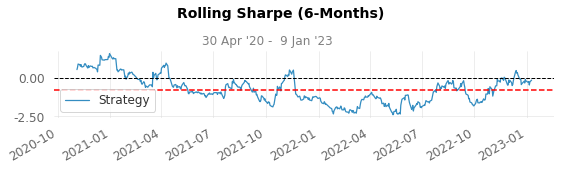

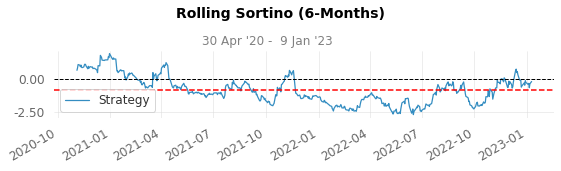

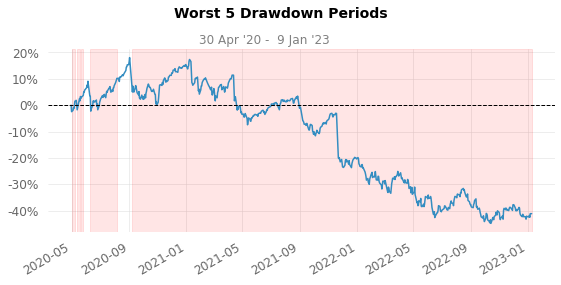

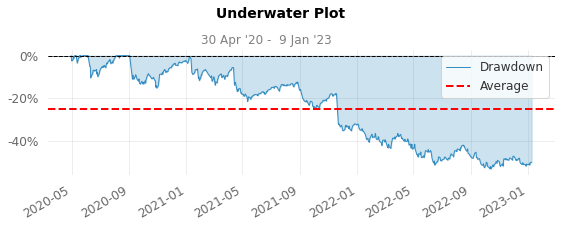

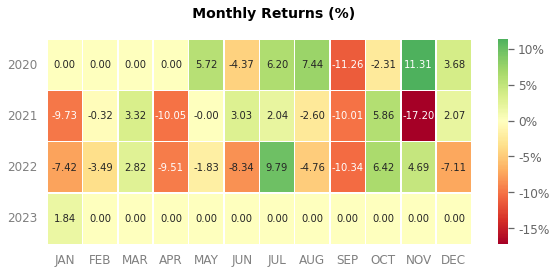

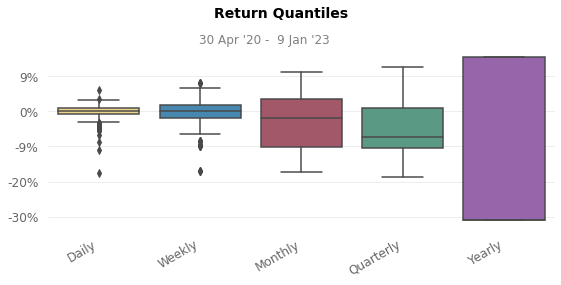

Report Generated in Colab as well as .html and .pdf


In [ ]:
generate_report('Tearsheet Generator', '2020-04-30')